In [1]:
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import sys
# setting path 
sys.path.append('../')
from NeuralNetworks.NNs import FCFF_3L
from PointSampling.Ball import data_gen_ball
from visualization.plots_disc import plot_2d_proj_disc
from visualization.disc_training import plot_2d_proj_w
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD 
from Training.training_finite_sum import train_finite_sum
from error_test.cube_error import FD_loss
from error_test.disc_error import error_ball

dim = 4

radii = [3., 0.]
domain = data_gen_ball(radii, dim)

#Right-hand-side of the PDE
def f(X): return 1

#Boundary condition
def g(X): return 0

delta_list = [.7, .5, .2, .1, .05]
alpha_list = [2., 2., 2., 2., 2.]
rounds = len(delta_list)
training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,
    
    'f': f, 
    'g': g, 
    'c': None,
    
    'beta': 0., ## parameter for the +u_i term 
    
    'lambda': 1. #weight parameter for the boundary loss
}

# Test data
x_grid = torch.linspace(-max(radii), max(radii), int(21))
print('delta_test = ', x_grid[1]-x_grid[0] )
X = torch.meshgrid([x_grid]*dim)
data_square = torch.cat([X[i].unsqueeze(-1) for i in range(dim)], dim = -1).reshape([-1, dim])
test_data = data_square[data_square.norm(dim = -1) < max(radii)]
print('Number of test points =', test_data.shape[0])

n_experiments = 2

delta_test =  tensor(0.3000)
Number of test points = 49059


/Users/carlosesteveyague/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Fixed collocation points I

In [2]:
MSE_history1 = torch.zeros([n_experiments, rounds])
L_inf_error_history1 = torch.zeros([n_experiments, rounds]) 

training_error_history1 = torch.zeros([n_experiments, rounds])
test_error_history1 = torch.zeros([n_experiments, rounds])

training_error_history1_max = torch.zeros([n_experiments, rounds])
test_error_history1_max = torch.zeros([n_experiments, rounds])


for j in range(n_experiments):
    # We initialise the NN
    NN1 = FCFF_3L([dim,30,30])
    training_params['optimizer'] = optim.SGD(NN1.parameters(), lr = .01, momentum = .2)
    
    ## Here we sample the collocation points and the boundary points.
    training_data_int = domain.rand_int_points(0., 800)
    training_data_bound = domain.rand_bound_points(400)
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 50

    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]
        
        total_loss, PDE_loss, boundary_loss = train_finite_sum(NN1, training_data_int, 
                                                               training_data_bound, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN1, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            training_error = FD_loss(NN1, training_data_int, training_params)
            test_error = FD_loss(NN1, test_data, training_params)
        
        training_error_history1[j,i] = training_error.mean()
        test_error_history1[j,i] = test_error.mean()
        training_error_history1_max[j,i] = training_error.max().item()
        test_error_history1_max[j,i] = test_error.max().item()
        
        MSE_history1[j,i] = MSE
        L_inf_error_history1[j,i] = L_inf
    
        #epochs =  training_params['epochs']
        #plt.plot(torch.arange(epochs)+1, total_loss)
        #plt.plot(torch.arange(epochs)+1, PDE_loss)
        #plt.plot(torch.arange(epochs)+1, boundary_loss)
        #plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
        #plt.show()
        
        #X_axis = 0
        #Y_axis = 1
        #n_grid = 100
        
        #plot_2d_proj_disc(X_axis, Y_axis, NN1, n_grid, n_grid, radii)
        #plot_2d_proj_w(X_axis, Y_axis, NN1, n_grid, radii, training_params,training_data_int)
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

  0%|          | 2/500 [00:00<00:36, 13.69it/s]

Mean square error: tensor(0.1043)
L-infinity error: tensor(1.7520)


  0%|          | 2/500 [00:00<00:36, 13.47it/s]

Mean square error: tensor(0.0634)
L-infinity error: tensor(1.4935)


  0%|          | 2/500 [00:00<00:36, 13.70it/s]

Mean square error: tensor(0.0135)
L-infinity error: tensor(0.8738)


  0%|          | 2/500 [00:00<00:38, 12.87it/s]

Mean square error: tensor(0.0052)
L-infinity error: tensor(0.5285)


  0%|          | 2/500 [00:00<00:37, 13.39it/s]

Mean square error: tensor(0.0106)
L-infinity error: tensor(0.4396)


  0%|          | 2/500 [00:00<00:37, 13.44it/s]

Mean square error: tensor(0.1047)
L-infinity error: tensor(1.7499)


  0%|          | 2/500 [00:00<00:43, 11.47it/s]

Mean square error: tensor(0.0602)
L-infinity error: tensor(1.4917)


  0%|          | 2/500 [00:00<00:37, 13.31it/s]

Mean square error: tensor(0.0160)
L-infinity error: tensor(0.9067)


  0%|          | 2/500 [00:00<00:37, 13.45it/s]

Mean square error: tensor(0.0043)
L-infinity error: tensor(0.5417)


100%|██████████| 500/500 [00:36<00:00, 13.74it/s]


Mean square error: tensor(0.0032)
L-infinity error: tensor(0.3518)


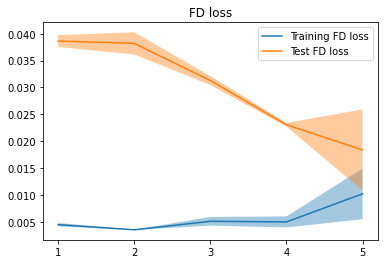

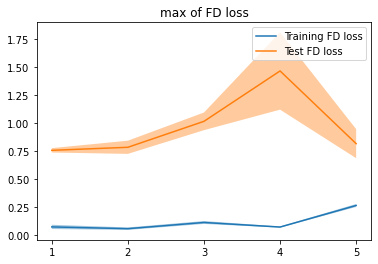

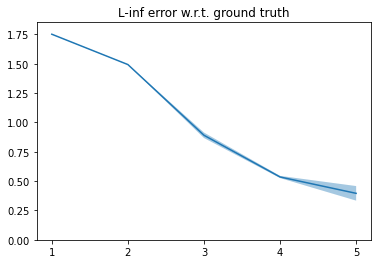

In [3]:
plt.plot(np.arange(rounds) , training_error_history1.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history1.mean(0) - training_error_history1.std(0), 
                training_error_history1.mean(0) + training_error_history1.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history1.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history1.mean(0) - test_error_history1.std(0),
                test_error_history1.mean(0) + test_error_history1.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history1_max.mean(0))
plt.fill_between(np.arange(rounds),
                 training_error_history1_max.mean(0) - training_error_history1_max.std(0),
                training_error_history1_max.mean(0) + training_error_history1_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history1_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history1_max.mean(0) - test_error_history1_max.std(0),
                test_error_history1_max.mean(0) + test_error_history1_max.std(0),
                alpha = .4)
#plt.ylim(0, test_error_history1_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history1.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history1.mean(0) - L_inf_error_history1.std(0),
                L_inf_error_history1.mean(0) + L_inf_error_history1.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history1.max().item()+0.1)
plt.title('L-inf error w.r.t. ground truth')
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.show()

# Fixed collocation points II


In [6]:
MSE_history2 = torch.zeros([n_experiments, rounds])
L_inf_error_history2 = torch.zeros([n_experiments, rounds]) 

training_error_history2 = torch.zeros([n_experiments, rounds])
test_error_history2 = torch.zeros([n_experiments, rounds])

training_error_history2_max = torch.zeros([n_experiments, rounds])
test_error_history2_max = torch.zeros([n_experiments, rounds])


for j in range(n_experiments):
    # We initialise the NN
    NN2 = FCFF_3L([dim,30,30])
    training_params['optimizer'] = optim.SGD(NN2.parameters(), lr = .01, momentum = .2)
    
    ## Here we sample the collocation points and the boundary points.
    training_data_int = domain.rand_int_points(0., 400)
    training_data_bound = domain.rand_bound_points(80)
    
    training_params['epochs'] = 500
    training_params['batch_size'] = 50

    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]
        
        total_loss, PDE_loss, boundary_loss = train_finite_sum(NN2, training_data_int, 
                                                               training_data_bound, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN2, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            training_error = FD_loss(NN2, training_data_int, training_params)
            test_error = FD_loss(NN2, test_data, training_params)
        
        training_error_history2[j,i] = training_error.mean()
        test_error_history2[j,i] = test_error.mean()
        training_error_history2_max[j,i] = training_error.max().item()
        test_error_history2_max[j,i] = test_error.max().item()
        
        MSE_history2[j,i] = MSE
        L_inf_error_history2[j,i] = L_inf
    
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

  1%|          | 4/500 [00:00<00:15, 31.06it/s]

Mean square error: tensor(0.1175)
L-infinity error: tensor(1.7825)


  1%|          | 4/500 [00:00<00:15, 31.81it/s]

Mean square error: tensor(0.0778)
L-infinity error: tensor(1.5337)


  1%|          | 3/500 [00:00<00:17, 28.17it/s]

Mean square error: tensor(0.0329)
L-infinity error: tensor(0.9879)


  1%|          | 4/500 [00:00<00:15, 32.29it/s]

Mean square error: tensor(0.0197)
L-infinity error: tensor(0.7187)


  1%|          | 3/500 [00:00<00:17, 27.77it/s]

Mean square error: tensor(0.0155)
L-infinity error: tensor(0.5359)


  1%|          | 3/500 [00:00<00:20, 24.54it/s]

Mean square error: tensor(0.1211)
L-infinity error: tensor(1.7819)


  0%|          | 2/500 [00:00<00:28, 17.48it/s]

Mean square error: tensor(0.0724)
L-infinity error: tensor(1.5215)


  1%|          | 3/500 [00:00<00:17, 28.30it/s]

Mean square error: tensor(0.0279)
L-infinity error: tensor(0.9512)


  1%|          | 3/500 [00:00<00:20, 24.21it/s]

Mean square error: tensor(0.0178)
L-infinity error: tensor(0.6624)


100%|██████████| 500/500 [00:15<00:00, 31.59it/s]


Mean square error: tensor(0.0138)
L-infinity error: tensor(0.4962)


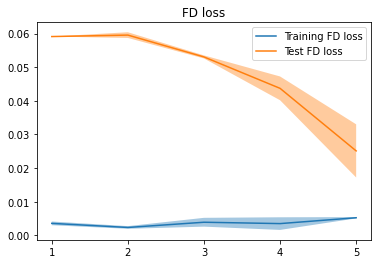

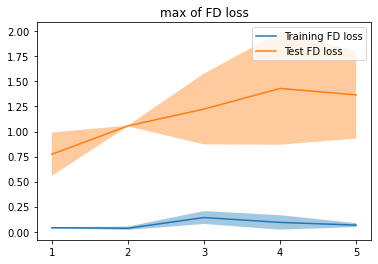

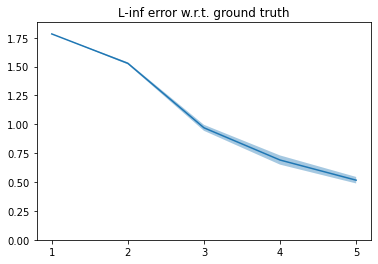

In [7]:
plt.plot(np.arange(rounds) , training_error_history2.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history2.mean(0) - training_error_history2.std(0), 
                training_error_history2.mean(0) + training_error_history2.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history2.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history2.mean(0) - test_error_history2.std(0),
                test_error_history2.mean(0) + test_error_history2.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history2_max.mean(0))
plt.fill_between(np.arange(rounds),
                 training_error_history2_max.mean(0) - training_error_history2_max.std(0),
                training_error_history2_max.mean(0) + training_error_history2_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history2_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history2_max.mean(0) - test_error_history2_max.std(0),
                test_error_history2_max.mean(0) + test_error_history2_max.std(0),
                alpha = .4)
#plt.ylim(0, test_error_history1_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history2.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history2.mean(0) - L_inf_error_history2.std(0),
                L_inf_error_history2.mean(0) + L_inf_error_history2.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history2.max().item()+0.1)
plt.title('L-inf error w.r.t. ground truth')
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.show()

# Re-sampling

In [8]:
MSE_history3 = torch.zeros([n_experiments, rounds])
L_inf_error_history3 = torch.zeros([n_experiments, rounds]) 

training_error_history3 = torch.zeros([n_experiments, rounds])
test_error_history3 = torch.zeros([n_experiments, rounds])

test_error_history3_max = torch.zeros([n_experiments, rounds])

from Training.training import train

training_params['n_coloc_points'] = 300
training_params['n_boundary_points'] = 50
n_ite = 2500
training_params['num_iterations'] = n_ite

for j in range(n_experiments):
    # We initialise the NN
    NN3 = FCFF_3L([dim,30,30])
    training_params['optimizer'] = optim.SGD(NN3.parameters(), lr = .01, momentum = .2)

    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[i]
        training_params['delta'] = delta_list[i]

        total_loss, PDE_loss, boundary_loss = train(NN3, domain, training_params)

        MC_points = int(1e5) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN3, max(radii), MC_points, display = False)
        
        with torch.no_grad():
            #training_error = FD_loss(NN2, training_data_int, training_params)
            test_error = FD_loss(NN3, test_data, training_params)
        
        training_error_history3[j,i] = PDE_loss[-1]
        test_error_history3[j,i] = test_error.mean()
        test_error_history3_max[j,i] = test_error.max().item()
        
        MSE_history3[j,i] = MSE
        L_inf_error_history3[j,i] = L_inf
        
        print('Mean square error:', MSE)
        print('L-infinity error:', L_inf)

  2%|▏         | 38/2500 [00:00<00:06, 378.41it/s]

Mean square error: tensor(0.1138)
L-infinity error: tensor(1.7773)


  2%|▏         | 38/2500 [00:00<00:06, 371.60it/s]

Mean square error: tensor(0.0669)
L-infinity error: tensor(1.5025)


  1%|▏         | 35/2500 [00:00<00:07, 349.08it/s]

Mean square error: tensor(0.0173)
L-infinity error: tensor(0.8907)


  1%|▏         | 37/2500 [00:00<00:06, 361.57it/s]

Mean square error: tensor(0.0055)
L-infinity error: tensor(0.5649)


  1%|▏         | 34/2500 [00:00<00:07, 331.63it/s]

Mean square error: tensor(0.0031)
L-infinity error: tensor(0.3616)


  1%|          | 17/2500 [00:00<00:14, 167.66it/s]

Mean square error: tensor(0.1154)
L-infinity error: tensor(1.7820)


  1%|▏         | 34/2500 [00:00<00:07, 336.65it/s]

Mean square error: tensor(0.0666)
L-infinity error: tensor(1.5059)


  1%|▏         | 35/2500 [00:00<00:07, 346.15it/s]

Mean square error: tensor(0.0167)
L-infinity error: tensor(0.8896)


  1%|▏         | 35/2500 [00:00<00:07, 345.50it/s]

Mean square error: tensor(0.0058)
L-infinity error: tensor(0.5597)


100%|██████████| 2500/2500 [00:06<00:00, 380.58it/s]


Mean square error: tensor(0.0029)
L-infinity error: tensor(0.3546)


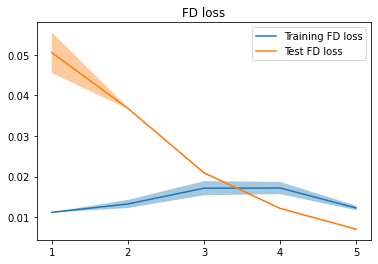

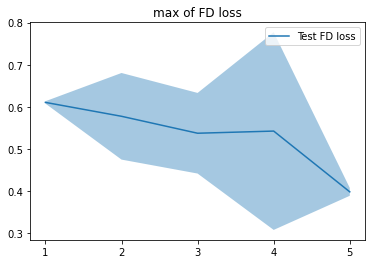

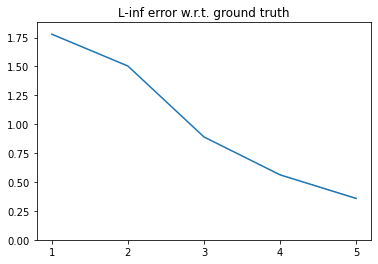

In [9]:
plt.plot(np.arange(rounds) , training_error_history3.mean(0))
plt.fill_between(np.arange(rounds) , 
                 training_error_history3.mean(0) - training_error_history3.std(0), 
                training_error_history3.mean(0) + training_error_history3.std(0), alpha=0.4)

plt.plot(np.arange(rounds) , test_error_history3.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history3.mean(0) - test_error_history3.std(0),
                test_error_history3.mean(0) + test_error_history3.std(0), alpha = 0.4)

plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , test_error_history3_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history3_max.mean(0) - test_error_history3_max.std(0),
                test_error_history3_max.mean(0) + test_error_history3_max.std(0),
                alpha = .4)
plt.legend(labels = ['Test FD loss'])
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history3.mean(0))
plt.fill_between(np.arange(rounds),
                L_inf_error_history3.mean(0) - L_inf_error_history3.std(0),
                L_inf_error_history3.mean(0) + L_inf_error_history3.std(0),
                alpha = .4)

plt.ylim(0, L_inf_error_history3.max().item()+0.1)
plt.xticks([i for i in range(rounds)], [i+1 for i in range(rounds)])
plt.title('L-inf error w.r.t. ground truth')
plt.show()

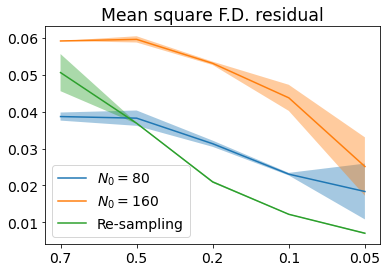

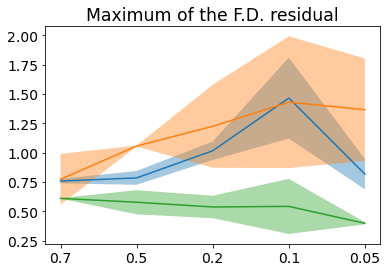

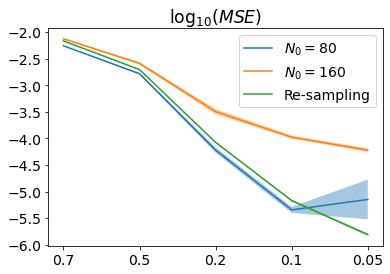

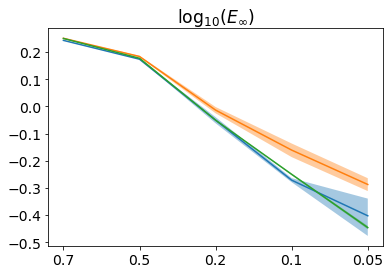

In [10]:
plt.plot(np.arange(rounds) , test_error_history1.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history1.mean(0) - test_error_history1.std(0),
                test_error_history1.mean(0) + test_error_history1.std(0), alpha = 0.4)

plt.plot(np.arange(rounds) , test_error_history2.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history2.mean(0) - test_error_history2.std(0),
                test_error_history2.mean(0) + test_error_history2.std(0), alpha = 0.4)

plt.plot(np.arange(rounds) , test_error_history3.mean(0))
plt.fill_between(np.arange(rounds), 
                test_error_history3.mean(0) - test_error_history3.std(0),
                test_error_history3.mean(0) + test_error_history3.std(0), alpha = 0.4)

plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Mean square F.D. residual', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds) , test_error_history1_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history1_max.mean(0) - test_error_history1_max.std(0),
                test_error_history1_max.mean(0) + test_error_history1_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history2_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history2_max.mean(0) - test_error_history2_max.std(0),
                test_error_history2_max.mean(0) + test_error_history2_max.std(0),
                alpha = .4)

plt.plot(np.arange(rounds) , test_error_history3_max.mean(0))
plt.fill_between(np.arange(rounds),
                test_error_history3_max.mean(0) - test_error_history3_max.std(0),
                test_error_history3_max.mean(0) + test_error_history3_max.std(0),
                alpha = .4)

#plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Maximum of the F.D. residual', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds), MSE_history1.log().mean(0))
plt.fill_between(np.arange(rounds),
                MSE_history1.log().mean(0) - MSE_history1.log10().std(0),
                MSE_history1.log().mean(0) + MSE_history1.log10().std(0),
                alpha = .4)

plt.plot(np.arange(rounds), MSE_history2.log().mean(0))
plt.fill_between(np.arange(rounds),
                MSE_history2.log().mean(0) - MSE_history2.log10().std(0),
                MSE_history2.log().mean(0) + MSE_history2.log10().std(0),
                alpha = .4)

plt.plot(np.arange(rounds), MSE_history3.log().mean(0))
plt.fill_between(np.arange(rounds),
                MSE_history3.log().mean(0) - MSE_history3.log10().std(0),
                MSE_history3.log().mean(0) + MSE_history3.log10().std(0),
                alpha = .4)

plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.show()


plt.plot(np.arange(rounds), L_inf_error_history1.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (L_inf_error_history1.mean(0) - L_inf_error_history1.std(0)).log10(),
                (L_inf_error_history1.mean(0) + L_inf_error_history1.std(0)).log10(),
                alpha = .4)

plt.plot(np.arange(rounds), L_inf_error_history2.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (L_inf_error_history2.mean(0) - L_inf_error_history2.std(0)).log10(),
                (L_inf_error_history2.mean(0) + L_inf_error_history2.std(0)).log10(),
                alpha = .4)

plt.plot(np.arange(rounds), L_inf_error_history3.mean(0).log10())
plt.fill_between(np.arange(rounds),
                (L_inf_error_history3.mean(0) - L_inf_error_history3.std(0)).log10(),
                (L_inf_error_history3.mean(0) + L_inf_error_history3.std(0)).log10(),
                alpha = .4)

#plt.legend(labels = ['$N_0 = 80$', '$N_0 = 160$', 'Re-sampling'], fontsize=14)
plt.xticks([i for i in range(rounds)], [ delta_list[i] for i in range(rounds)])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.show()